# Walk on Spheres implementation for 2D domains

Implementación basada en [esto](https://www.cs.cmu.edu/~kmcrane/Projects/MonteCarloGeometryProcessing/WoSPoisson2D.cpp.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Gball(r, R):
    ''' Green function for the ball of radius R (See Evans PDE book) '''
    return np.nan_to_num(np.log(R/r)) / (2*np.pi)

In [3]:
def WoS2D(x0, mesh, f, g, bnd_tol=1e-3, nwalkers=20, nsteps=10):
    '''
    '''
    retval = 0
    #  Perform nwalks random walks and take the mean
    for w in range(nwalkers):
        x = x0
        steps = 0
        bnd_dist = float('inf')
        #  For every random walk, walk till the boundary
        while bnd_dist > bnd_tol and steps < nsteps:
            bnd_dist = mesh.dist2bnd(x)
            
            r = bnd_dist * np.random.uniform()
            t = np.random.uniform(0, 2*np.pi)
            
            y = x + np.array([r*np.cos(t), r*np.sin(t)])
            retval += bnd_dist**2 * f(y) * Gball(r, bnd_dist)
            
            s = np.random.uniform(0, 2*np.pi)
            x = x + np.array([bnd_dist*np.cos(s), bnd_dist*np.sin(s)])
            
            steps += 1
        retval += g(x)
    return retval/nwalkers

In [4]:
class MyMesh:
    
    def __init__(self, mesh):
        self.mesh = mesh
    
    def dist2bnd(self, p):
        ''' This should be changed based on the mesh implementation '''
        min_dist = float('inf')
        for segment in self.mesh:
            a, b = segment
            proy = np.clip(np.dot(b-a, p-a) / np.dot(b-a, b-a), 0.0, 1.0)
            closest = (1-proy)*a + proy*b
            min_dist = min(min_dist, np.linalg.norm(p-closest))
        return min_dist

In [5]:
#  Unit square
mesh = MyMesh([
    [np.array([0.0, 0.0]), np.array([0.0, 1.0])],
    [np.array([0.0, 0.0]), np.array([1.0, 0.0])],
    [np.array([1.0, 0.0]), np.array([1.0, 1.0])],
    [np.array([0.0, 1.0]), np.array([1.0, 1.0])],
])

/tmp/ipykernel_13732/3008557703.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.nan_to_num(np.log(R/r)) / (2*np.pi)


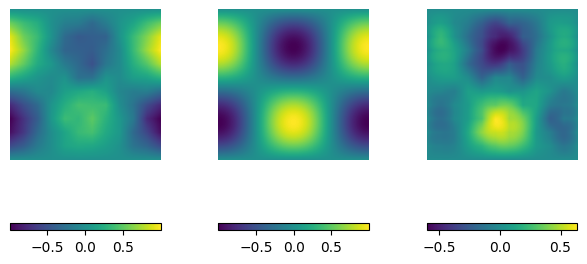

In [8]:
from scipy.interpolate import RegularGridInterpolator

#  PDE data
uexact = lambda x: np.cos(2*np.pi*x[0]) * np.sin(2*np.pi*x[1])
f = lambda x: 8*np.pi*2 * np.cos(2*np.pi*x[0]) * np.sin(2*np.pi*x[1])
g = lambda x: np.cos(2*np.pi*x[0]) * np.sin(2*np.pi*x[1])


#  Compute approximation
sampling_factor = 10+2
x = np.linspace(0, 1, sampling_factor)
y = np.linspace(0, 1, sampling_factor)
grid_values = np.zeros((sampling_factor, sampling_factor))

for j, y0 in enumerate(y):
    for i, x0 in enumerate(x):
        grid_values[i][j] = WoS2D(np.array([x0, y0]), mesh, f, g, nwalkers=200)

#  Interpolate data to generate images
interp = RegularGridInterpolator((x,y), grid_values)
canvas_scale = 256
grid = np.meshgrid(np.linspace(0, 1, canvas_scale), np.linspace(0, 1, canvas_scale))
uh = interp(np.dstack(grid)).reshape((-1, 2)).reshape((canvas_scale, canvas_scale))

u = uexact(grid).reshape((canvas_scale, canvas_scale))


#  Ploting
fig, ax = plt.subplots(ncols=3)
fig.tight_layout()
for i, img in enumerate([uh, u, u-uh]):
    p = ax[i].imshow(img)
    ax[i].axis('off')
    fig.colorbar(p, ax=ax[i], location='bottom')

plt.show()